In [1]:

import scanpy as sc
import pandas as pd
from pathlib import Path
import gzip


In [2]:
adata=sc.read_h5ad('Data/combined_raw.h5ad')

c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
#5. QC filtering
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Mitochondrial gene filter
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.pct_counts_mt < 5, :]  # Keep cells with <5% mito reads
print(f"After QC: {adata.shape}")


c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


After QC: (14746, 22519)


In [4]:
#Normalization and log transformation 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

In [17]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [11]:
output_path = Path("Data/adata_raw_qc.h5ad")
adata.write(output_path)
print(f"Saved AnnData object to {output_path}")


Saved AnnData object to Data\adata_raw_qc.h5ad


In [7]:
adata

AnnData object with n_obs × n_vars = 14746 × 2000
    obs: 'sample', 'title', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'taxid_ch1', 'characteristics_ch1.0.tissue', 'characteristics_ch1.1.subject status', 'molecule_ch1', 'extract_protocol_ch1', 'description', 'data_processing', 'platform_id', 'contact_email', 'contact_phone', 'contact_department', 'instrument_model', 'library_selection', 'library_source', 'library_strategy', 'relation', 'supplementary_file_1', 'supplementary_file_2', 'supplementary_file_3', 'series_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'gene_symbol', 'ensembl_id', 'feature_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    

In [8]:
!pip3 install igraph

In [9]:
!pip3 install leidenalg

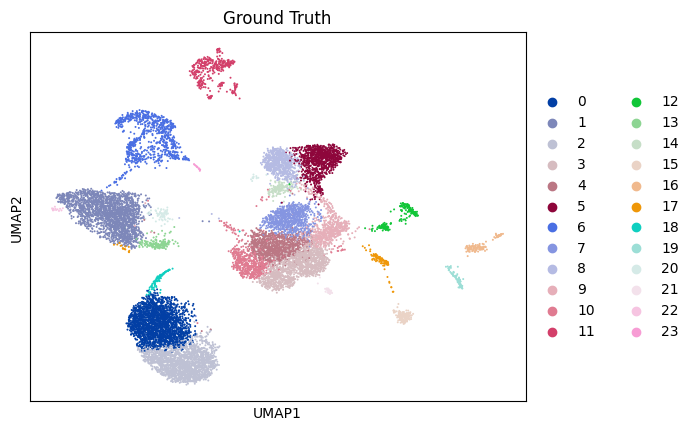

In [18]:
sc.pl.umap(adata, color='leiden', title='Ground Truth', save='_GT_UMAP.png')

In [23]:
# Use gene_symbol as var_names
adata.var['gene_symbol'] = adata.var['gene_symbol'].astype(str)  # convert from object
adata.var_names = adata.var['gene_symbol']

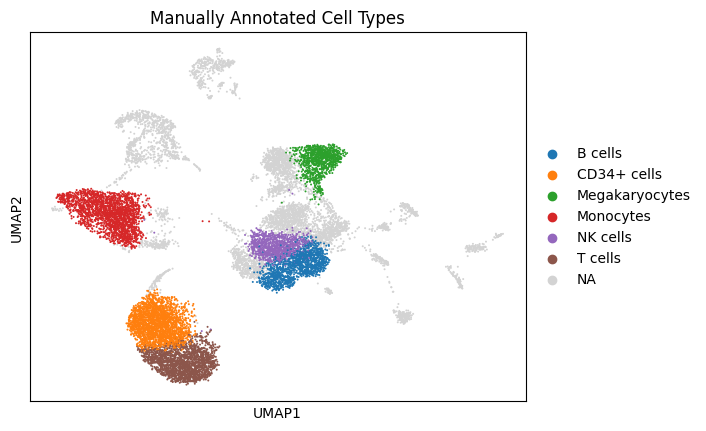

In [24]:
# Example: Map Leiden clusters to cell types manually
cluster_to_celltype = {
    '0': 'CD34+ cells',
    '1': 'Monocytes',
    '2': 'T cells',
    '3': 'B cells',
    '4': 'NK cells',
    '5': 'Megakaryocytes'
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

# Visualize annotated UMAP
sc.pl.umap(adata, color='cell_type', title='Manually Annotated Cell Types', save='_Annotated_UMAP.png')


Markers available for plotting: ['PF4', 'PPBP', 'MS4A1']


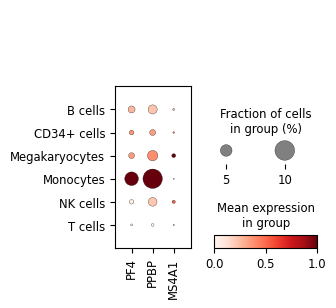

In [36]:
# 6. Make gene names unique
adata.var_names_make_unique()

# 7. Dotplot of all markers
markers = ['CD34','PF4','PPBP','CD19','MS4A1','NCAM1','NKG7','KLRD1','CD3D','CD3E','CD3G','CD14','LYZ']
markers_present = [g for g in markers if g in adata.var_names]
print("Markers available for plotting:", markers_present)

sc.pl.dotplot(
    adata,
    var_names=markers_present,
    groupby='cell_type',
    standard_scale='var',
    save='_Dotplot_CellTypes.png'
)


In [22]:
adata.var

,gene_ids,gene_symbol,ensembl_id,feature_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
gene,,,,,,,,,,,,,,
ENSG00000237094,ENSG00000237094,[nan],ENSG00000237094,ENSG00000237094,426,False,426,0.004541,99.550116,430.0,True,0.036274,2.577872,-0.067959
ISG15,ENSG00000187608,['ISG15'],ENSG00000187608,ISG15,33204,False,33204,0.673475,64.934365,63772.0,True,0.779551,2.999858,-0.785290
ENSG00000224969,ENSG00000224969,[nan],ENSG00000224969,ENSG00000224969,9,False,9,0.000095,99.990495,9.0,True,0.001155,2.563340,-0.122956
ENSG00000260179,ENSG00000260179,[nan],ENSG00000260179,ENSG00000260179,63,False,63,0.000708,99.933468,67.0,True,0.001482,2.644221,0.183154
TAS1R3,ENSG00000169962,['TAS1R3'],ENSG00000169962,TAS1R3,134,False,134,0.001552,99.858487,147.0,True,0.004126,2.462836,-0.503333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TFF3,ENSG00000160180,['TFF3'],ENSG00000160180,TFF3,246,False,246,0.004647,99.740208,440.0,True,0.196916,3.335829,2.800678
COL18A1,ENSG00000182871,['COL18A1'],ENSG00000182871,COL18A1,2696,False,2696,0.031999,97.152845,3030.0,True,0.174736,2.482807,-0.427749
SLC19A1,ENSG00000173638,['SLC19A1'],ENSG00000173638,SLC19A1,3769,False,3769,0.042940,96.019685,4066.0,True,0.227459,2.587338,-0.213617


In [26]:
# Use gene_symbol column as var_names
adata.var['gene_symbol'] = adata.var['gene_symbol'].astype(str)

# Clean list-like strings e.g. "['CD34']"
adata.var['gene_symbol'] = adata.var['gene_symbol'].str.replace("[\[\]']", "", regex=True)

# Set gene_symbol as index
adata.var_names = adata.var['gene_symbol']
adata.var_names_make_unique()


In [27]:
markers = ['CD34','PF4','PPBP','CD19','MS4A1','NCAM1','NKG7','KLRD1','CD3D','CD3E','CD3G','CD14','LYZ']
markers_present = [g for g in markers if g in adata.var_names]
print("Markers available for plotting:", markers_present)


Markers available for plotting: ['PF4', 'PPBP', 'MS4A1']


In [35]:
import scgenome
# Or use scANVI (from scvi-tools) if you have a reference dataset 


ModuleNotFoundError: No module named 'scgenome'

In [33]:
!pip install scgenome

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      Traceback (most recent call last):
        File "C:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
        File "C:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
        File "C:\Users\prath\Downloads\ScRnaseq_research\venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 143, in get_requires_for_build_wheel
          return hook(config_settings)
        File "C:\Users\prath\AppData\Local\Temp\pip-build-env-9o6feq1j\overlay\Lib\site-packages\setuptools\build_meta.py", line 331, in get_requires_for_build_wheel
          return self._get_bu

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False, save='_cluster_markers.png')
